In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

bands_number = 15
autosimilarity_types = ["Cosine", "RBF"]
pen_function = "modulo8"#["Nope", "modulo_oracle_salami"]
features = ["log_mel_grill"] #["mel_grill","log_mel_grill", "nn_log_mel_grill", "pcp", "mfcc-nmfcc32"]
features_labels = ["Log Mel"]#["Mel", "Log Mel", "NNLMS", "Chromagram", "MFCC"]

lambda_range = np.concatenate([np.arange(0.1, 0.3, 0.1)])#2.1, 0.1)])

In [10]:
def learn_and_test_salami(lambda_range, feature = "log_mel_grill", autosimilarity_type = "cosine", bands_number = bands_number, penalty_func = "modulo8"):
    """
    Learning the latent space dimension on the non-test subset of the SALAMI dataset, and computes the results on the SALAMI test-dataset.
    """
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    
    results_songs_lambdas = -math.inf * np.ones((len_salami, len(lambda_range), 2, 3))
    lengths_all_lambda = []
    for i in range(len(lambda_range)):
        lengths_all_lambda.append([])
        
    hop_length = 32
    hop_length_seconds = hop_length/44100
    subdivision_bars = 96
    
    all_tracks = salami.load_tracks()    
    song_idx = 0
    file_mirex = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_mirex.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))
            
    for key, track in all_tracks.items():
        if int(key) not in test_dataset: # Every other file than the test dataset
            try:
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)

                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision_bars)
                if np.isnan(tensor_barwise).any():
                    print(f"Nan here: {key}")
                
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
 
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_in_bars = np.array(dm.segments_from_time_to_bar(references_segments, bars))
                    ref_tab.append(ref_in_bars)
                except (TypeError, AttributeError):
                    pass

                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_in_bars = np.array(dm.segments_from_time_to_bar(references_segments, bars))
                    ref_tab.append(ref_in_bars)
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    for idx_lambda, lambda_penalty in enumerate(lambda_range):
                        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                

                        #segments_in_time = dm.segments_from_bar_to_time(segments, bars)
                        for end, start in segments:
                            lengths_all_lambda[idx_lambda].append(start - end)
                        prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments, window_length = 0)
                        prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments, window_length = 1)
                        this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                        if len(ref_tab) > 1:
                            nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments, window_length = 0)
                            nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments, window_length = 1)
                            if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                                this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                        results_songs_lambdas[song_idx, idx_lambda] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in learning at song {key}, {track}")
                
            except FileNotFoundError:
                print(f"{key} not found, normal ?")
                
    #for idx_lambda, lambda_penalty in enumerate(lambda_range):
        #print(lambda_penalty)
        #plot_lenghts_hist(lengths_all_lambda[idx_lambda])

    avg_songs = [np.mean(results_songs_lambdas[:song_idx, i, 0, 2]) + np.mean(results_songs_lambdas[:song_idx, i, 1, 2]) for i in range(len(lambda_range))]
    best_lambda_idx = np.argmax(avg_songs)
    print(f"Best lambda: {lambda_range[best_lambda_idx]}")

    return fixed_conditions_results_salami(lambda_range[best_lambda_idx], feature = feature, autosimilarity_type = autosimilarity_type, bands_number = bands_number, penalty_func = penalty_func)    

def fixed_conditions_results_salami(lambda_penalty, feature = "log_mel_grill", autosimilarity_type = "cosine", bands_number = bands_number, penalty_func = "modulo8"):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    lengths = []
    results = -math.inf * np.ones((len_salami, 2, 3))
    
    hop_length = 32
    hop_length_seconds = hop_length/44100
    subdivision_bars = 96
    
    all_tracks = salami.load_tracks()
    
    song_idx = 0
    
    file_test_set_gs = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_test_set_gs.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))

    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision_bars)

                tensor_barwise = tl.tensor(tensor_barwise)
                
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
  
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    try:
                        ref_in_bars = np.array(dm.segments_from_time_to_bar(references_segments, bars))
                        ref_tab.append(ref_in_bars)
                    except:
                        pass
                except (TypeError, AttributeError):
                    pass
                    
                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    try:
                        ref_in_bars = np.array(dm.segments_from_time_to_bar(references_segments, bars))
                        ref_tab.append(ref_in_bars)
                    except:
                        pass
                except (TypeError, AttributeError):
                    pass
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
                    #segments_in_time = dm.segments_from_bar_to_time(segments, bars)
                    for end, start in segments:
                        lengths.append(start - end)

                    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments, window_length = 0)
                    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments, window_length = 1)
                    this_score = [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

                    if len(ref_tab) > 1:
                        nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments, window_length = 0)
                        nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments, window_length = 1)
                        if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
                            this_score = [[round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)], [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]]
                    results[song_idx] = np.array(this_score)
                    song_idx += 1
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"{key} not found, normal ?")

    print(f"Tested on {song_idx} songs")
    lines = np.array(["Precision 0bar", "Recall 0bar", "F measure 0bar","Precision 1bar", "Recall 1bar", "F measure 1bar"])  
    results_cropped = results[:song_idx]
    #display(pd.DataFrame([round(np.mean(results_cropped[:,0, 0]),5), round(np.mean(results_cropped[:, 0,1]),5), round(np.mean(results_cropped[:, 0,2]),5), round(np.mean(results_cropped[:,1, 0]),5), round(np.mean(results_cropped[:, 1,1]),5), round(np.mean(results_cropped[:, 1,2]),5)], columns=["Barwise FT"], index=lines).T)
    return lengths, np.array([[round(np.mean(results_cropped[:,0, 0]),5), round(np.mean(results_cropped[:, 0,1]),5), round(np.mean(results_cropped[:, 0,2]),5)], [round(np.mean(results_cropped[:,1, 0]),5), round(np.mean(results_cropped[:, 1,1]),5), round(np.mean(results_cropped[:, 1,2]),5)]])

def get_segment_sizes_repartition_from_autosimilarity_penalty_arg(autosimilarity, bars, references_segments, penalty_func, lambda_penalty, bands_number = bands_number):
    lengths = []
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = lambda_penalty, penalty_func = penalty_func, bands_number = bands_number)[0]                
    for end, start in segments:
        lengths.append(start - end)
    print(lengths)
    return lengths

In [18]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 18})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.set_ylim( 25, 110 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='upper left')
    else:
        ax.legend(labels=subaxis, loc='upper left', ncol = 3)

    ax.set_ylabel("F measure")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

Kernel: 15
Feature: log_mel_grill
Autosimilarity type: Cosine
70 not found, normal ?
Tested on 486 songs
Autosimilarity type: RBF
70 not found, normal ?
Tested on 486 songs


,P0.5,R0.5,F0.5,P3,R3,F3
Autosimilarity: Cosine,0.383780,0.359160,0.356950,0.522210,0.481570,0.482590
Autosimilarity: RBF,0.461910,0.538250,0.481230,0.596400,0.695060,0.621350


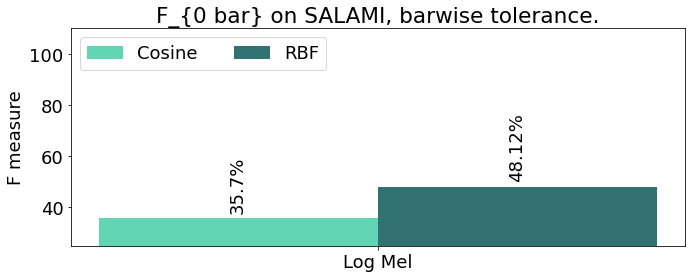

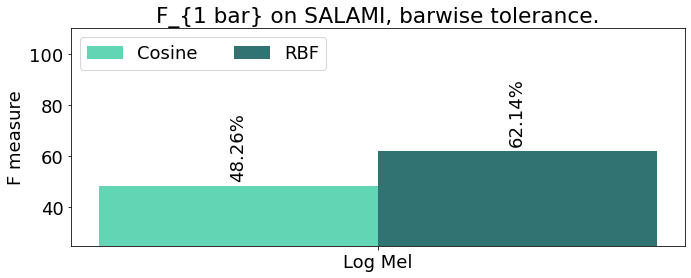

In [13]:
print(f"Kernel: {bands_number}")

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 3))
tab_as = [0.1,0.2]
for idx_feat, feature in enumerate(features):
    print(f"Feature: {feature}")
    indexes = []
    results_this_function = math.inf * np.ones((len(autosimilarity_types), 2, 3))

    for idx_as, autosimil_type in enumerate(autosimilarity_types):
        print(f"Autosimilarity type: {autosimil_type}")
        lengths, res = fixed_conditions_results_salami(tab_as[idx_as], feature = "log_mel_grill", autosimilarity_type = autosimil_type, bands_number = 15, penalty_func = "modulo8")

        #lengths, res = learn_and_test_salami(lambda_range, feature = feature, autosimilarity_type = autosimil_type, bands_number = bands_number, penalty_func = pen_function)
        #plot_lenghts_hist(lengths)
        results_this_function[idx_as] = res
        indexes.append(f"Autosimilarity: {autosimil_type}")
    res_avg_target[idx_feat] = results_this_function
    dataframe = pd.DataFrame(results_this_function.reshape(results_this_function.shape[0], 6), columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = "F_{0 bar} on SALAMI, barwise tolerance.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = "F_{1 bar} on SALAMI, barwise tolerance.")

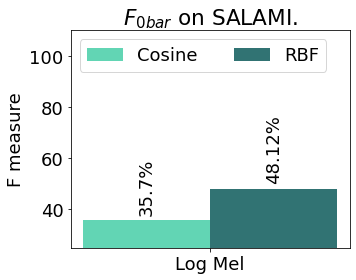

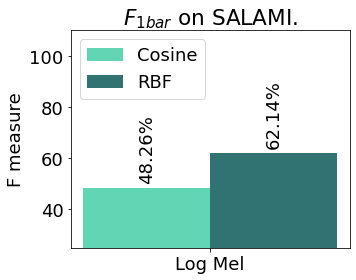

In [24]:
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 0, title = "$F_{0 bar}$ on SALAMI.")
plot_kernels_as(np.round(100 * res_avg_target[:,:,:,2], decimals = 2), features_labels, autosimilarity_types, 1, title = "$F_{1 bar}$ on SALAMI.")

In [20]:
np.round(100 * res_avg_target[:,:,:,2], decimals = 2)

array([[[35.7 , 48.26],
        [48.12, 62.14]]])

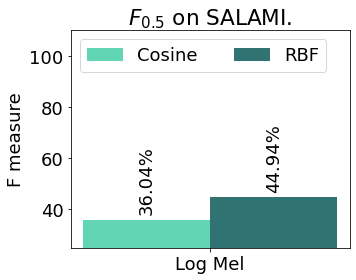

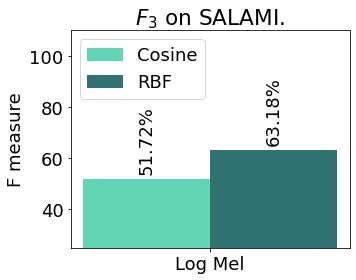

In [26]:
plot_kernels_as(np.array([[[36.04 , 51.72],[44.94, 63.18]]]), features_labels, autosimilarity_types, 0, title = "$F_{0.5}$ on SALAMI.")
plot_kernels_as(np.array([[[36.04 , 51.72],[44.94, 63.18]]]), features_labels, autosimilarity_types, 1, title = "$F_{3}$ on SALAMI.")